In [1]:
import git
import datetime

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import OneHotEncoder

# import the module from the file
from avg_interpolation import avg_interpolation_np_array
from preprocessing import minmax_scaler, piecewise_log

In [2]:
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir


In [3]:
#import daily covid cases per county
counties_df = pd.read_csv(f"{homedir}/data/us/covid/nyt_us_counties_daily.csv")
counties_df = counties_df[counties_df['state'].notna()] #drop rows where state is NaN value

In [4]:
#one hot encode states and add column to dataframe
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
states = np.array(counties_df['state']).reshape(-1, 1)
one_hot_encoder.fit(states)
states_encoded = one_hot_encoder.transform(states).toarray()

counties_df['states_encoded'] = states_encoded.tolist() #add column to dataframe

#convert date to datetime format
counties_df['date'] = pd.to_datetime(counties_df['date'])

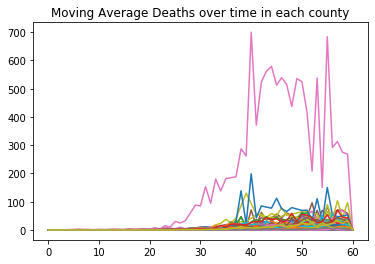

<Figure size 432x288 with 0 Axes>

In [6]:
split_point = 40 #for splitting into training and testing data

#initialize lists
inputs_total = []
conditions_total = []

train_inputs = []
train_targets = []
train_conditions = []

test_inputs = []
test_targets = []
test_conditions = []

fips = set(np.array(counties_df['fips'])) #list of unique fips

dateshift = 35 #so here the first 35 days are like all 0 so i shifted the data we're interested in back by 35 days
daterange = pd.date_range(min(counties_df['date'] + datetime.timedelta(days = dateshift)),
                          max(counties_df['date'])).tolist() #range of dates 


fips_fewcases = [] #store fips of cases that are too few to model
fips_manycases = [] #store fips of cases that we are modeling with RNN

for i in fips: #iterate through counties 
    c_df = counties_df[counties_df['fips'] == i] #county specific dataframe
        
    if max(c_df['deaths']) <= 2: #don't do anything if there are too few cases 
        fips_fewcases.append(i)
    
    elif max(c_df['deaths']) > 2:
        
        x1 = np.zeros(len(daterange)) #x1 stores cases
        x2 = np.zeros(len(daterange)) #x2 stores deaths

        c_daterange = c_df['date'].tolist() #daterange for this specific counties

        for j in range(len(daterange)): #populating time series data for each county  
            if daterange[j] in c_daterange: #if there is data for the county for this date, populate x1 and x2
                x1[j] = c_df[c_df['date'] == daterange[j]]['cases'].values[0]
                x2[j] = c_df[c_df['date'] == daterange[j]]['deaths'].values[0]
        
        # compute moving averages of cases and deaths data over 5 days
        x3 = avg_interpolation_np_array(x1, .5)
        x4 = avg_interpolation_np_array(x2, .5)

        days = np.arange(0, len(x1)) #range of days... to indicate progression of disease?
        
        plt.plot(days, x4) #plot moving avg deaths
        
        x = np.stack((piecewise_log(x1), piecewise_log(x2), days), axis = 1) #construct input data
        
        x_train = x[:split_point] #split into training and testing
        x_test = x[split_point:]
        
        inputs_total.append(x)
        
        #construct conditions... one hot encoded states
        p = counties_df[counties_df['fips'] == i]['states_encoded'].values[0]
        conditions_total.append(np.array(p))
        
        #break up into little batch thingies
        data_gen_train = TimeseriesGenerator(x_train, x_train,
                                       length=10, sampling_rate=1,
                                       batch_size=2)
        
        data_gen_test = TimeseriesGenerator(x_test, x_test,
                                       length=10, sampling_rate=1,
                                       batch_size=2)

        #construct training data
        for k in range(len(data_gen_train)):
            x_b, y_b = data_gen_train[k]
            
            for l in range(len(x_b)):

                x_batch = x_b[l]
                y_batch = y_b[l]
                
                train_inputs.append(x_batch)
                train_targets.append(y_batch)

                #conditions   
                train_conditions.append(np.array(p))
        
        #construct test data
        for k in range(len(data_gen_test)):
            x_b, y_b = data_gen_test[k]
            
            for l in range(len(x_b)):

                x_batch = x_b[l]
                y_batch = y_b[l]
                
                test_inputs.append(x_batch)
                test_targets.append(y_batch)

                #conditions   
                test_conditions.append(np.array(p))

plt.title('Moving Average Deaths over time in each county')      
plt.figure()
                
#make things into arrays
test_inputs = np.array(test_inputs)
test_targets = np.array(test_targets)
test_conditions = np.array(test_conditions)

train_inputs = np.array(train_inputs)
train_targets = np.array(train_targets)
train_conditions = np.array(train_conditions)

inputs_total = np.array(inputs_total)
conditions_total = np.array(conditions_total)
